# Projetinho de implementação do algoritmo Regressão Linear

Autor: Renata Leite

Dataset utilizado: https://www.kaggle.com/datasets/sohier/calcofi

## Introdução

In [ ]:
# Importando as bibliotecas necessárias:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Lendo o dataset:
data = pd.read_csv('bottle.csv')

In [ ]:
# Apresentando as 5 primeiras linhas:
data.head(5)

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preparando o dataset e apresentando o problema

O dataset original contém 864862 linhas e 74 colunas. Para nossa regressão linear, porém, usaremos apenas 2 dessas colunas: 'Salnty' e 'T_degC', relacionadas, respectivamente, à salinidade e à temperatura da água. Nosso objetivo será analisar a relação entre essas features - e, mais especificamente, prever valores de temperatura (que será nossa variável dependente, y) com base na salinidade (usada como variável independente ou explicativa, x).

In [ ]:
# Criando um dataset apenas com 'Salnty' e 'T_degC' e renomeando as colunas:
data = data[['Salnty', 'T_degC']]
data.set_axis(['Salinity', 'Temperature'], axis='columns', inplace=True)

data.head()

,Salinity,Temperature
0,33.440,10.50
1,33.440,10.46
2,33.437,10.46
3,33.420,10.45
4,33.421,10.45


#### Limpeza

Agora, para a limpeza dos dados, veremos se há algum valor nulo ou suspeito para excluirmos.

In [ ]:
# Procurando valores nulos:
data.isnull().sum()

Salinity       47354
Temperature    10963
dtype: int64

In [ ]:
# Dropando as linhas com elementos nulos:
data.dropna(inplace=True)

In [ ]:
data.isnull().sum()

Salinity       0
Temperature    0
dtype: int64

In [ ]:
# Procurando valores suspeitos:
data.describe()

,Salinity,Temperature
count,814247.000000,814247.000000
mean,33.841337,10.860287
std,0.461636,4.224930
min,28.431000,1.440000
25%,33.489000,7.750000
50%,33.866000,10.110000
75%,34.197000,13.930000
max,37.034000,31.140000


Não há nenhum valor suspeito.

#### Treino x teste

Agora, separaremos nossos dados em conjunto de treino e conjunto de teste para, futuramente, verificarmos nosso algoritmo. Queremos "embaralhar" esses dados, modificando a ordenação das linhas para que os dados não sejam divididos linearmente - assim, usaremos 'shuffle = True' e 'random_state = 1'.

In [ ]:
# Dividindo os dados em conjunto de treino e conjunto de teste:
from sklearn.model_selection import train_test_split
data_treino, data_teste = train_test_split(data, test_size=0.3, random_state=1, shuffle=True)
data_treino = data_treino.reset_index(drop = True)
data_teste = data_teste.reset_index(drop = True)

In [ ]:
data_treino.head()

,Salinity,Temperature
0,33.2072,14.352
1,33.6000,10.050
2,34.2080,7.660
3,34.1600,6.280
4,33.9320,7.890


Agora, vamos visualizar os dados de treino:

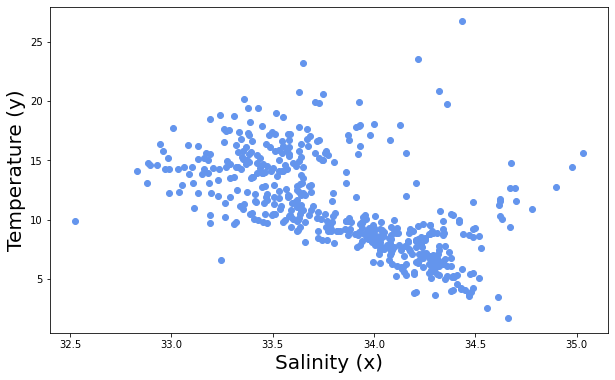

In [ ]:
# Separando uma amostra diminuta dos dados de treino:
amostra_treino = data_treino[:][:500]

# Plotando data_treino:
plt.figure(figsize=(10,6))
plt.scatter(amostra_treino['Salinity'], amostra_treino['Temperature'], color='cornflowerblue')
plt.xlabel('Salinity (x)', fontsize=20)
plt.ylabel('Temperature (y)', fontsize=20)
plt.show()

Com a visualização gráfica, fica evidente a existência de certa relação linear entre a variáveis dependente e independente. Sendo assim, podemos traçar uma linha que melhor se ajusta aos dados e, dessa forma, extrapolar nosso conjunto através de predições.

## Implementando um regressor linear simples

In [ ]:
def calcula_media(array):
  """ Calcula a média de uma dada array.
  Entrada: uma array.
  Saída: sua média.                  """
  return (np.sum(array) / len(array))

def calcula_variancia(array):
  """ Calcula a variância (medida de dispersão) de uma dada array.
  Entrada: uma array.
  Saída: sua variância.                  """
  media = calcula_media(array)
  return np.sum((array - media)**2)

def calcula_covariancia(array_x, array_y):
  """ Calcula a covariância (ou grau de interdependência) entre duas variáveis.
  Entrada: duas arrays.
  Saída: a covariância existente.                                           """
  media_x = calcula_media(array_x)
  media_y = calcula_media(array_y)
  array_final = (array_x - media_x)*(array_y - media_y)
  return np.sum(array_final)


def calcula_coeficientes(x, y):
  """ Estima os coeficientes ('intercept' e 'slope') para a regressão linear.
  Entrada: os dados x e y.
  Saída: os coeficientes 'a' e 'b'.                                       """
  media_x = calcula_media(x)
  media_y = calcula_media(y)
  # Pensar na fórmula da regressão linear: "y = bx + a", então "a = y - bx" (intercepto) e "b = cov / var" (coeficiente angular ou 'slope').
  b = (calcula_covariancia(x, y) / calcula_variancia(x))
  a = media_y - media_x * b
  return a, b

def regressao_linear(x_treino, y_treino, x_teste):
  """ Regressor linear.
  Entrada: os dados de treino (x e y) e o x de teste, que será usado para fazer previsões.
  Saída: os valores de y preditos para os dados de teste.                              """
  predicao = []
  a, b = calcula_coeficientes(x_treino, y_treino)
  for x in x_teste:
    y = b*x + a
    predicao.append(y)
  return predicao

Agora aplicaremos nossa função aos dados, e usaremos também o algoritmo do scikit learn para posteriormente compararmos as métricas.

In [ ]:
# Prevendo as temperaturas com nosso regressor linear:
y_previsto = regressao_linear(data_treino['Salinity'], data_treino['Temperature'], data_teste['Salinity'])

In [ ]:
# Prevendo as temperaturas o regressor linear do slkearn:
from sklearn.linear_model import LinearRegression
x_treino = np.array(data_treino['Salinity']).reshape((-1, 1))
y_treino = np.array(data_treino['Temperature'])
x_teste = np.array(data_teste['Salinity']).reshape((-1, 1))


modelo = LinearRegression().fit(x_treino, y_treino)
y_previsto_sklearn = modelo.predict(x_teste)

Por último, podemos usar algumas métricas para verificar a qualidade do algoritmo:

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
y_teste = data_teste['Temperature']

r2 = r2_score(y_previsto, y_teste)
print("O coeficiente de determinação (R²) do nosso algoritmo é:", r2)
r2_sklearn = r2_score(y_previsto_sklearn, y_teste)
print("O coeficiente de determinação (R²) do algoritmo do sklearn é:", r2_sklearn)

mse = mean_squared_error(y_previsto, y_teste)
print("\nO erro quadrático médio (MSE) do nosso algoritmo é:", mse)
mse_sklearn = mean_squared_error(y_previsto_sklearn, y_teste)
print("O erro quadrático médio (MSE) do algoritmo do sklearn é:", mse_sklearn)

O coeficiente de determinação (R²) do nosso algoritmo é: -1.8982777721531834
O coeficiente de determinação (R²) do algoritmo do sklearn é: -1.8982777721531825

O erro quadrático médio (MSE) do nosso algoritmo é: 13.321458581975222
O erro quadrático médio (MSE) do algoritmo do sklearn é: 13.321458581975222


### Referências utilizadas:

- https://towardsdatascience.com/linear-regression-modelling-oceanographic-data-fdc3a98813bf
- https://machinelearningmastery.com/implement-simple-linear-regression-scratch-python/
- https://www.analyticsvidhya.com/blog/2021/06/getting-started-with-machine-learning%E2%80%8A-%E2%80%8Aimplementing-linear-regression-from-scratch/
- https://www.ibm.com/br-pt/analytics/learn/linear-regression